# Basic usage of PHYSBO

## Introduction

In this tutorial, we will introduce how to define the simulator class and find the minimum value of a one-dimensional function using PHYSBO.

First, we will import PHYSBO.

In [1]:
import physbo

## Defining the search space

In the following example, the search space ``X`` is defined as a grid chopped by ``window_num=10001`` divisions from ``x_min = -2.0`` to ``x_max = 2.0``.
Note that ``X`` must be in ``window_num`` x ``d`` ndarray format (``d`` is the number of dimensions, in this case one). In this case, ``d`` is the number of dimensions, in this case two, so we use reshape to transform it.

In [2]:
#In
import numpy as np
import scipy
import physbo
import itertools

#In
#Create candidate
window_num=10001
x_max = 2.0
x_min = -2.0

X = np.linspace(x_min,x_max,window_num).reshape(window_num, 1)

## Defining the simulator class

Here, we define the simulator class to set as the objective function.

In this case, the problem is to find the minimum $x$ such that $f(x) = 3 x^4 + 4 x ^3 + 1.0$ (the answer is $x=-1.0$).

In the simulator class, we define the ``__call__`` function (or ``__init__`` if there are initial variables, etc.).
(If there are initial variables, define ``__init__``.) The action indicates the index number of the grid to be retrieved from the search space, and is generally in the form of an ndarray so that multiple candidates can be calculated at once.
In this case, we choose one candidate point from ``X`` as ``action_idx=action[0]`` to calculate only one candidate at a time.
Since **PHYSBO is designed to find the maximum value of the objective function**, it returns the value of f(x) at the candidate point multiplied by -1.

In [3]:
# Declare the class for calling the simulator.
class simulator:

    def __call__(self, action ):
        action_idx = action[0]
        x = X[action_idx][0]
        fx = 3.0*x**4 + 4.0*x**3 + 1.0
        fx_list.append(fx)
        x_list.append(X[action_idx][0])

        print ("*********************")
        print ("Present optimum interactions")

        print ("x_opt=", x_list[np.argmin(np.array(fx_list))])

        return -fx

## Performing optimization

### Setting policy

First, set the optimization `policy`.  

Next, set `test_X` to the matrix of search candidates (`numpy.array`).

In [4]:
# set policy 
policy = physbo.search.discrete.policy(test_X=X)

# set seed
policy.set_seed(0)

When `policy` is set, no optimization is done yet.
Execute the following methods on `policy` to optimize it.

- `random_search`.  
- `bayes_search`.

If you specify the `simulator` and the number of search steps in these methods, the following loop will be executed for the number of search steps.

i) Select the next parameter to be executed from the candidate parameters.

ii) Execute `simulator` with the selected parameters.

The default number of parameter returned by i) is one, but it is possible to return multiple parameters in one step.
See the section "Searching for multiple candidates at once" for details.  

Also, instead of running the above loop inside PHYSBO, it is possible to control i) and ii) separately from the outside. In other words, it is possible to propose the next parameter to be executed from PHYSBO, evaluate its objective function value in some way outside PHYBO (e.g., by experiment rather than numerical calculation), propose it in some way outside PHYSBO, and register the evaluated value in PHYSBO. For more details, please refer to the "Running Interactively" section of the tutorial.

### Random Search

First of all, let's perform a random search.

Since Bayesian optimization requires at least two objective function values to be obtained (the initial number of data required depends on the problem to be optimized and the dimension d of the parameters), we will first perform a random search.   

**argument**.  

- `max_num_probes`: Number of search steps.  
- `simulator`: The simulator of the objective function (an object of class simulator). 

In [ ]:
fx_list=[]
x_list = []

res = policy.random_search(max_num_probes=20, simulator=simulator())

When executed, the objective function value and its action ID for each step, and the best value up to now and its action ID will be printed as follows.

````
0020-th step: f(x) = -19.075990 (action=8288)
   current best f(x) = -0.150313 (best action=2949) 
````


### Bayesian Optimization

Next, we run the Bayesian optimization as follows.

**argument**.  

- `max_num_probes`: Number of search steps.  
- `simulator`: The simulator of the objective function (an object of class simulator).  
- `score`: The type of acquisition function. You can specify one of the following
    - TS (Thompson Sampling)  
    - EI (Expected Improvement)  
    - PI (Probability of Improvement)  
- `interval`:  
The hyperparameters are trained at the specified interval.  
If a negative value is specified, no hyperparameter will be learned.  
0 means that hyperparameter learning will be performed only in the first step.  
- `num_rand_basis`: Number of basis functions. 0 means that a normal Gaussian process without Bayesian linear model will be used.  

In [ ]:
res = policy.bayes_search(max_num_probes=50, simulator=simulator(), score='TS', 
                                                  interval=0, num_rand_basis=500)

## Checking the results

The search result ``res`` is returned as an object of the ``history`` class (`physbo.search.discrete.results.history`).  
The following is a reference to the search results.

- `res.fx` : The history of evaluated values of simulator (objective function).
- `res.chosen_actions`: The history of action IDs (parameters) when the simulator was evaluated.  
- `fbest, best_action= res.export_all_sequence_best_fx()`: The history of best values and their action IDs (parameters) for all timings when the simulator was evaluated.
- `res.total_num_search`: Total number of simulator evaluations.

Let's plot the objective function value and the best value at each step.  
`res.fx` and `best_fx` should range up to `res.total_num_search`, respectively.

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

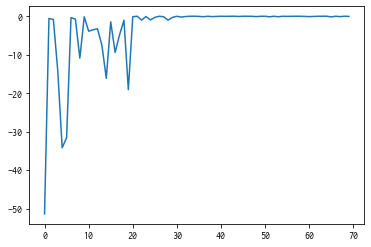

In [8]:
plt.plot(res.fx[0:res.total_num_search])

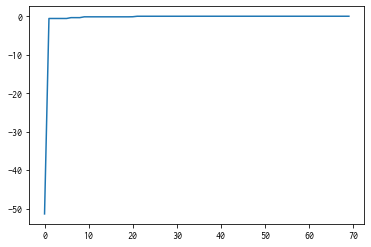

In [9]:
best_fx, best_action = res.export_all_sequence_best_fx()
plt.plot(best_fx)

## Serializing the results

The search results can be saved to an external file using the `save` method.

In [10]:
res.save('search_result.npz')

In [11]:
del res

Load the saved result file as follows:

In [12]:
res = physbo.search.discrete.results.history()
res.load('search_result.npz')

Finally, the candidate with the best score can be displayed as follows. You can see that we have arrived at the correct solution $x=-1$.

In [13]:
print(X[int(best_action[-1])])

[-1.002]


## Prediction

`policy` serves `get_post_fmean` and `get_post_fcov` methods for calculating mean value and variance of Gaussian process (post distribution). 

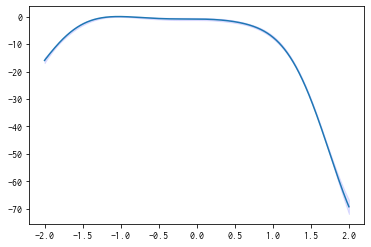

In [14]:
mean = policy.get_post_fmean(X)
var = policy.get_post_fcov(X)
std = np.sqrt(var)
xs = X[:,0]

ax = plt.subplot()
ax.plot(xs, mean)
ax.fill_between(xs, mean-std, mean+std, color="blue", alpha=.1)

## Acquisition function

`policy` serves `get_score` method for calculating acquisition function.

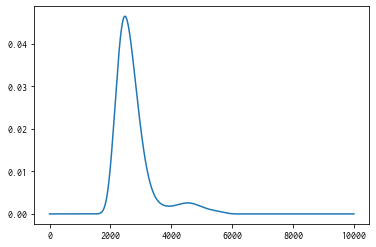

In [15]:
scores = policy.get_score(mode="EI", xs=X)
plt.plot(scores)

## Parallelization

PHYSBO can calculate acquisition functions for candidates in parallel by using MPI via `mpi4py` .
To enable MPI parallelization, pass a MPI communicator such as `MPI.COMM_WORLD` to a keyword argument, `comm` of the constructor of the `policy`.

In [16]:
# from mpi4py import MPI
# policy = physbo.search.discrete.policy(test_X=X, comm=MPI.COMM_WORLD)